In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import statsmodels.tsa.stattools as kpss
import warnings
warnings.filterwarnings("ignore")

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
arr1 =  np.random.normal(0,1,100)
arr2 =  np.random.normal(0,10,100) + np.arange(0, 100, 1)

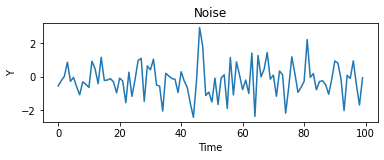

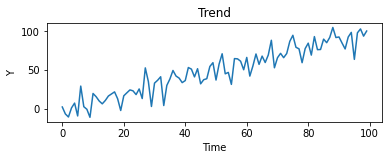

In [3]:
t = np.arange(0, 100, 1)
plt.subplot(2,1,1)
plt.plot(t, arr1)
plt.title('Noise')
plt.ylabel('Y')
plt.xlabel('Time')
plt.show()

plt.subplot(2,1,2)
plt.plot(t, arr2)
plt.title('Trend')
plt.ylabel('Y')
plt.xlabel('Time')
plt.show()

In [4]:
print(sm.tsa.stattools.kpss(arr1, regression='c')[0:2])
print(sm.tsa.stattools.kpss(arr2, regression='c')[0:2])

(0.07873335784418563, 0.1)
(0.8791449570456285, 0.01)


In [6]:
from google.colab import files
import io

uploaded = files.upload()
df = pd.read_csv(io.BytesIO(uploaded['spending_by_day.csv']))
# df = pd.read_csv('spending_by_day.csv')
#df['data'] = df.data.apply(lambda x: x[0:10].encode().decode('utf-8'))
df['data'] = df.data.apply(lambda x: x[0:10])
df['data'] = pd.to_datetime(df.data, errors='coerce')
df.set_index('data', inplace=True)
df.head()

Saving spending_by_day.csv to spending_by_day.csv


,sum
data,
2018-01-01,1.897892e+06
2018-01-02,5.438664e+06
2018-01-03,5.628547e+06
2018-01-04,6.056366e+06
2018-01-05,6.064084e+06


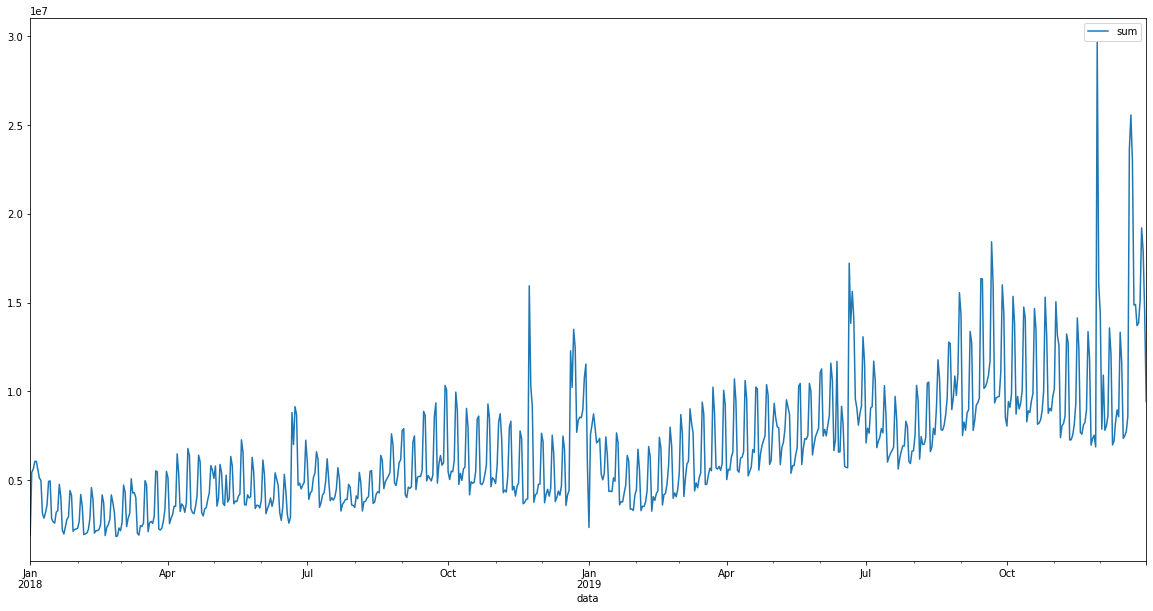

In [7]:
df.plot(figsize=(20,10))

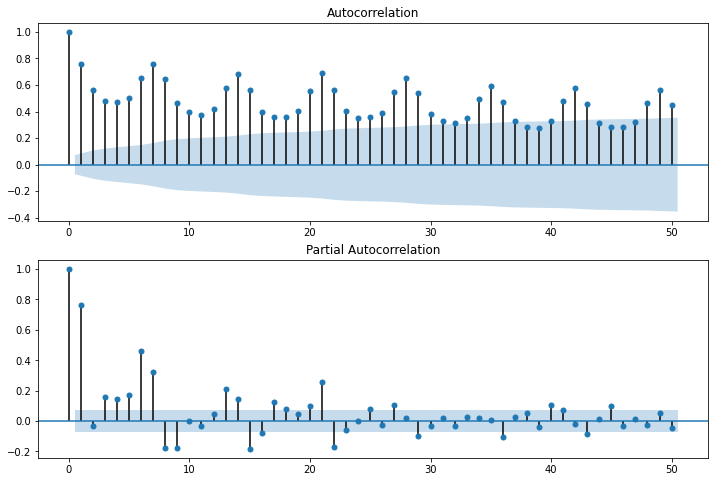

In [8]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df.values.squeeze(), lags=50, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df, lags=50, ax=ax2)

In [9]:
src_data_model = df[:'2019-11-01']
src_data_model
model = sm.tsa.ARIMA(src_data_model, order=(6,2,1)).fit(full_output=False, disp=0)

In [14]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                 D2.sum   No. Observations:                  668
Model:                 ARIMA(6, 2, 1)   Log Likelihood              -10378.611
Method:                       css-mle   S.D. of innovations        1339715.624
Date:                Sat, 15 May 2021   AIC                          20775.222
Time:                        15:35:29   BIC                          20815.760
Sample:                    01-03-2018   HQIC                         20790.926
                         - 11-01-2019                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           38.5549     59.354      0.650      0.516     -77.778     154.888
ar.L1.D2.sum    -0.5376      0.034    -15.693      0.000      -0.605      -0.470
ar.L2.D2.sum    -0.7016      0.031    -22.945      0.000      -0.761      -0.642
ar.L3.D2.sum    -0.5990      0.034    -17.688      0.000      -0.665      -0.533
ar.L4.D2.sum    -0.5972      0.034    -17.703      0.000      -0.663      -0.531
ar.L5.D2.sum    -0.6661      0.031    -21.806      0.000      -0.726      -0.606
ar.L6.D2.sum    -0.4727      0.034    -13.805      0.000      -0.540      -0.406
ma.L1.D2.sum    -0.9999      0.004   -249.901      0.000      -1.008      -0.992
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.6700           -0.7956j            1.0402           -0.1386
AR.2            0.6700           +0.7956j            1.0402            0.1386
AR.3           -0.2243           -1.0670j            1.0903           -0.2830
AR.4           -0.2243           +1.0670j            1.0903            0.2830
AR.5           -1.1503           -0.5671j            1.2825           -0.4271
AR.6           -1.1503           +0.5671j            1.2825            0.4271
MA.1            1.0001           +0.0000j            1.0001            0.0000
-----------------------------------------------------------------------------
"""

In [11]:
pred = model.predict('2019-11-01','2020-02-01', typ='levels')

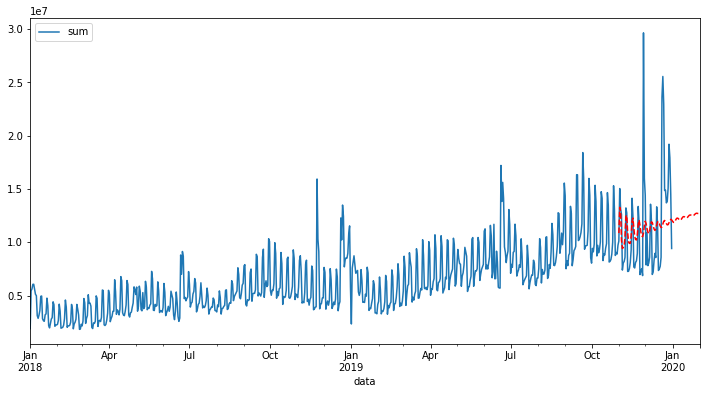

In [12]:
df.plot(figsize=(12,6))
pred.plot(style='r--')

# Домашнее задание

## Проведите изначальную предобработку

In [174]:
def box_cox(x, lamb):
  if lamb == 0:
    return np.log(x)
  else:
    return (x ** lamb - 1) / lamb

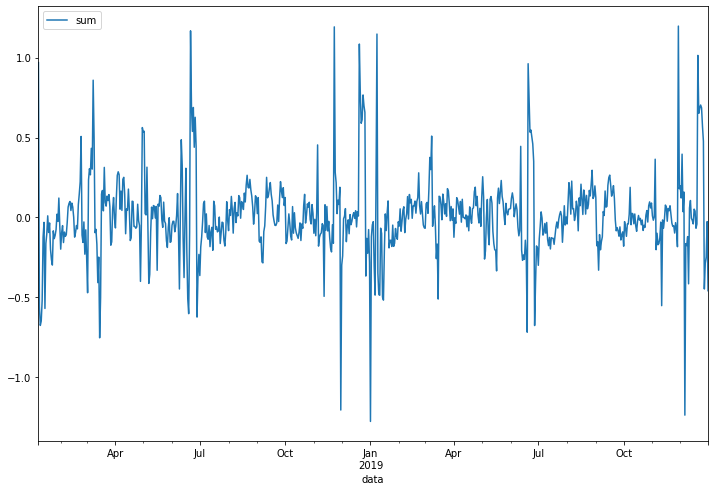

In [175]:
df_diff = df.copy(deep=True)
df_diff['sum'] = df_diff['sum'].apply(lambda x: box_cox(x, 0))

df_diff1 = df_diff.diff(periods=7).dropna()
df_diff1.plot(figsize=(12,8))

In [176]:
print(sm.tsa.stattools.kpss(np.array(df_diff1).T[0], regression='c')[0:2])

(0.08832009020040273, 0.1)


## Определите какие d и D надо взять

В предварительной обработке данных уже была произведена одна итерация дифференцирования для исключения сезонности, что позволило привести ряд к стационарному, поэтому d=D=1. Предположим сезонность s = 7

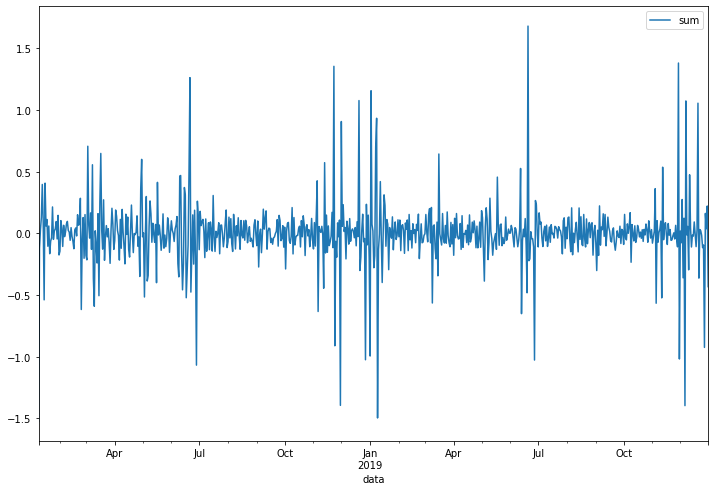

In [177]:
df_diff2 = df_diff1.diff(periods=1).dropna()
df_diff2.plot(figsize=(12,8))

In [178]:
print(sm.tsa.stattools.kpss(np.array(df_diff2).T[0], regression='c')[0:2])

(0.049358616476839264, 0.1)


## Подберите наулучшую модель из класса ARIMA

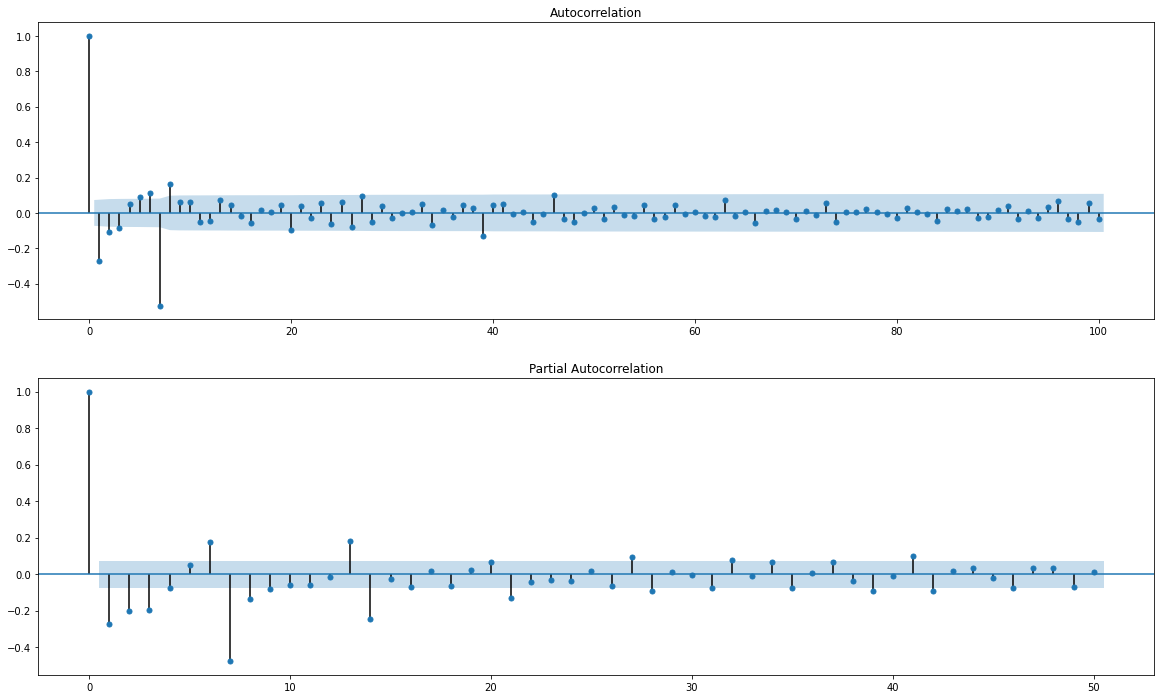

In [179]:
fig = plt.figure(figsize=(20,12))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df_diff2.values.squeeze(), lags=100, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df_diff2, lags=50, ax=ax2)

Таким образом, для сезонности s = 7:
**q = 6, Q = 1, p = 6, P = 4**

Оценка моделей:

In [180]:
arima_data_model = df_diff[:'2019-09-01']
arima_model = sm.tsa.ARIMA(arima_data_model, order=(6,1,6)).fit(full_output=False, disp=0)
arima_model.aic

-373.7727753323268

In [181]:
sarima_data_model = df_diff[:'2019-09-01']
sarima_model = sm.tsa.SARIMAX(sarima_data_model, order=(6,1,6), seasonal_order=(4,1,1,7)).fit(full_output=False, disp=0)
sarima_model.aic

-436.6726541205129

## Для обучения возьмиет период [:'2019-09-01']. Выведете график полученных предсказаний с ['2019-09-01'] и реальных значение всего ряда

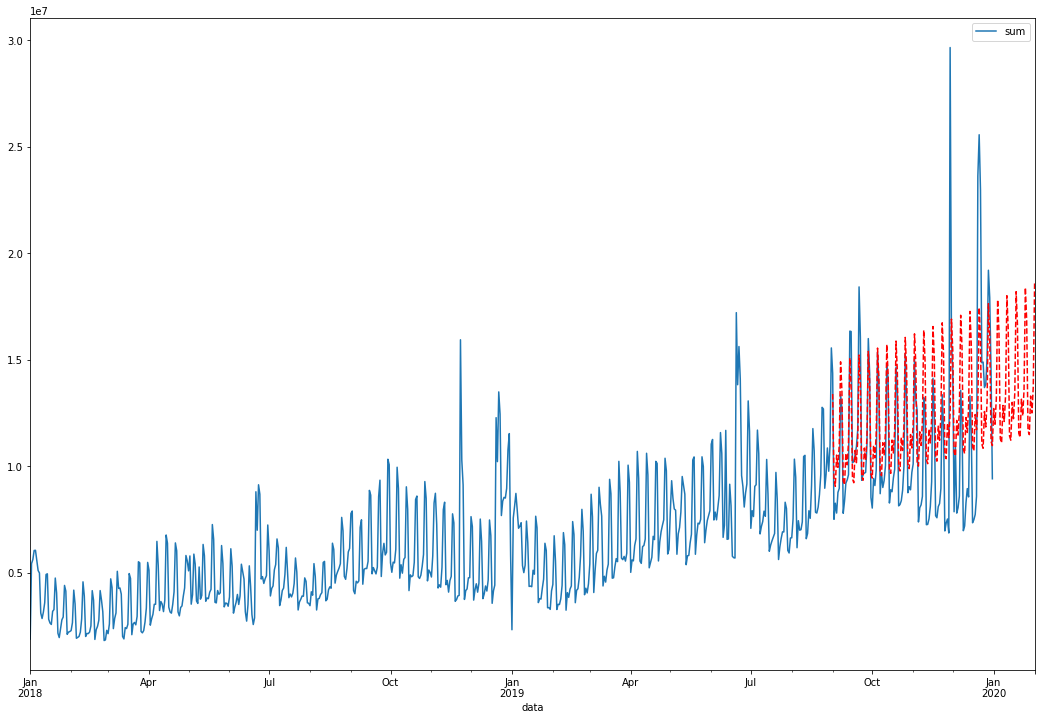

In [182]:
arima_pred = arima_model.predict('2019-09-01','2020-02-01', typ='levels')
arima_pred = np.exp(arima_pred)
df.plot(figsize=(18,12))
arima_pred.plot(style='r--')

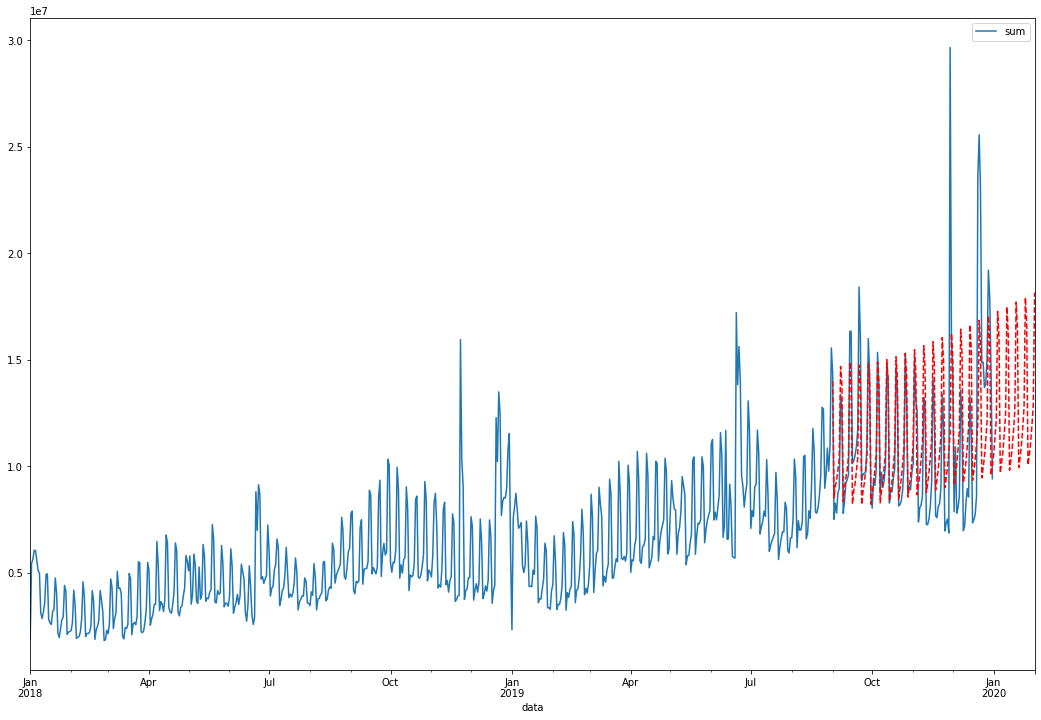

In [183]:
sarima_pred = sarima_model.predict('2019-09-01','2020-02-01', typ='levels')
sarima_pred = np.exp(sarima_pred)
df.plot(figsize=(18,12))
sarima_pred.plot(style='r--')

## Посмотрите на получившиеся ошибки. Что вы думаете о них.

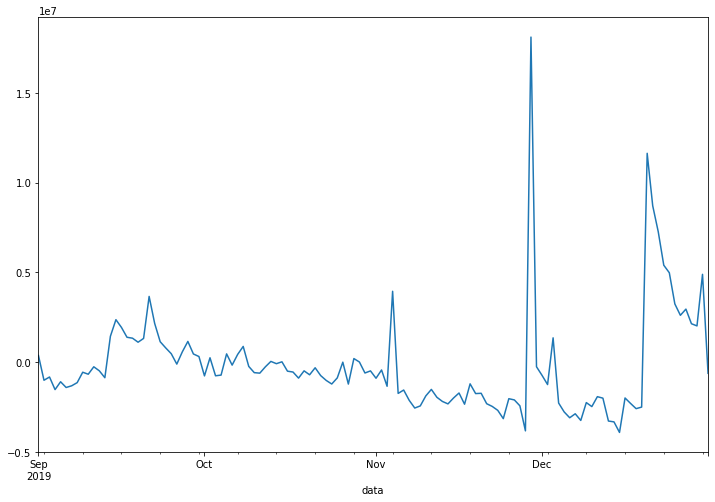

In [194]:
diffs = df['sum']['2019-09-01':'2019-12-31'] - sarima_pred['2019-09-01':'2019-12-31']
plt.figure(figsize=(12,8))
diffs.plot()

В данном случае мало данных, чтобы проявить годовую сезонность (а для месячной s=30 SARIMA бесконечно считала, я не представлял, через сколько это закончится), поэтому оставалось брать недельную сезонность. Обе модели хорошо спрогнозировали среднуюю ширину пика, но не исключительную ситуацию в декабре. Возможно, при наличии большего количества данных или возможности расчитать модель SARIMA для годовой сезонности, модель получилась бы сильно лучше.

Ошибки модели распределены около нуля, но после ноября начались большие колебания ввиду другого характера колебаний, которые модель не смогла усвоить и спрогнозировать.